### Importamos bibliotecas

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import cv2
import skimage
from skimage.transform import resize
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/asl-alphabet
/kaggle/input/asl-alphabet/asl_alphabet_test
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test
/kaggle/input/asl-alphabet/asl_alphabet_train
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/R
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/space
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/B
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/I
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/del
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/F
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/H
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/E
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/U
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train

### Cargando los datos 

Las imagenes originalmente median 200x200 pero debido a la capacidad de computo que se requiere no es posible hacerlo con las dimensiones originales por lo que decidi usar un tamaño menor pero que conservara todas las caracteristicas

In [2]:
batch_size = 32 #tamaño del lote
imageSize = 64 #tamaño de la imagen
target_dims = (imageSize, imageSize, 3)
num_classes = 29
train_len = 87000
train_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'
test_dir = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'

In [3]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']

### Generamos los datos 

In [4]:
def data_generation(folder, num):
    X = np.empty((train_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((train_len,), dtype=np.int)
    i = 0
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            for image_filename in os.listdir(os.path.join(folder, folderName)): #creamos la ruta del archivo
                img_file = cv2.imread(os.path.join(folder, folderName, image_filename))
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))#reconfiguramos el valor
                    img_arr = np.asarray(img_file).reshape((-1, imageSize, imageSize, 3))
                    X[i] = img_arr
                    y[i] = classes.index(folderName)
                    i += 1
                    if i % num == 0:
                        break
        
    return X,y
X_train, y_train = data_generation(train_dir, train_len/num_classes)

In [5]:
print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("Image shape : ", X_train[0].shape)

X_train shape :  (87000, 64, 64, 3)
y_train shape :  (87000,)
Image shape :  (64, 64, 3)


### Exploracion de los datos 

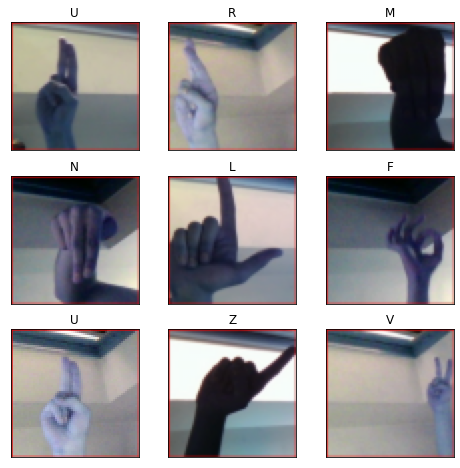

In [6]:
#Ploteamos algunas imagenes de el conjunto de datos 
f, axs = plt.subplots(2,2,figsize=(8,8))
for i in range (0,9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    img_nbr = np.random.randint(0,len(X_train))
    plt.imshow(X_train[img_nbr])
    plt.title(classes[y_train[img_nbr]])

### Procesamos los datos

In [7]:
# hacemos una copia de los datos
X_data = X_train
y_data = y_train

In [8]:
#Creamos los conjuntos de entrenamiento y testo
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,stratify=y_data)

In [10]:
# Tranformamos la salida de one hot encoding
from tensorflow.keras.utils import to_categorical
y_cat_train = to_categorical(y_train,29)
y_cat_test = to_categorical(y_test,29)

In [11]:
# Dimensiones de nuestros datos 

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(y_cat_train.shape)
print(y_cat_test.shape)

(69600, 64, 64, 3)
(69600,)
(17400, 64, 64, 3)
(17400,)
(69600, 29)
(17400, 29)


## Modelo

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten

In [13]:
#Creamos el modelo 
#Despues de varias pruebas este fue el numero de capaz que mejores resultados arrojo
model = Sequential([
    Conv2D(32, (5, 5), input_shape=(imageSize, imageSize, 3)), # Usamos el tamaño de las imagenes
    Activation('relu'), #funcion de activacion relu
    MaxPooling2D((2, 2)), #usamos la funcion de muestro maxpooling con un filtro de 2,2
    
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
   
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    #Colocamos el dropout
    tf.keras.layers.Dropout(rate=0.3),
    
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(29, activation='softmax') # 29 clases correpondientes a cada uno de los etiquetas que tenemos
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
activation (Activation)      (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        3

In [14]:
### detenmos las epocas cuando el modelo no mejora
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [15]:
# Definimos el optimizador, la función de perdidas y la métrica
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
#entrenamos
history = model.fit(
    X_train, y_cat_train,
    epochs=50,
    batch_size=64,
    verbose=2,
    validation_data=(X_test, y_cat_test),
    callbacks=[early_stop]
)

Epoch 1/50
1088/1088 - 261s - loss: 1.2546 - accuracy: 0.6157 - val_loss: 0.3160 - val_accuracy: 0.8967
Epoch 2/50
1088/1088 - 257s - loss: 0.2629 - accuracy: 0.9096 - val_loss: 0.1081 - val_accuracy: 0.9692
Epoch 3/50
1088/1088 - 257s - loss: 0.1481 - accuracy: 0.9500 - val_loss: 0.0543 - val_accuracy: 0.9829
Epoch 4/50
1088/1088 - 255s - loss: 0.0954 - accuracy: 0.9674 - val_loss: 0.0284 - val_accuracy: 0.9922
Epoch 5/50
1088/1088 - 258s - loss: 0.0789 - accuracy: 0.9732 - val_loss: 0.0456 - val_accuracy: 0.9855
Epoch 6/50
1088/1088 - 255s - loss: 0.0690 - accuracy: 0.9774 - val_loss: 0.0317 - val_accuracy: 0.9895


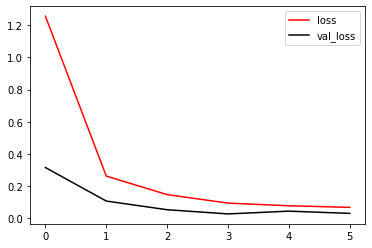

In [18]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot(color = ("red","black") )
plt.show()

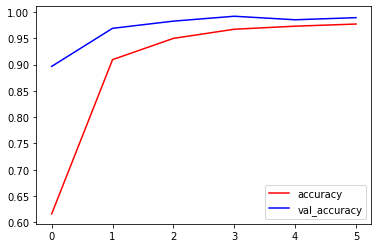

In [20]:
history_df.loc[0:, ['accuracy','val_accuracy']].plot(color=("red","blue"))
plt.show()

## Predictions

In [25]:
# realizamos una prueba de prediccion
predictions = np.argmax(model.predict(X_test), axis=-1)

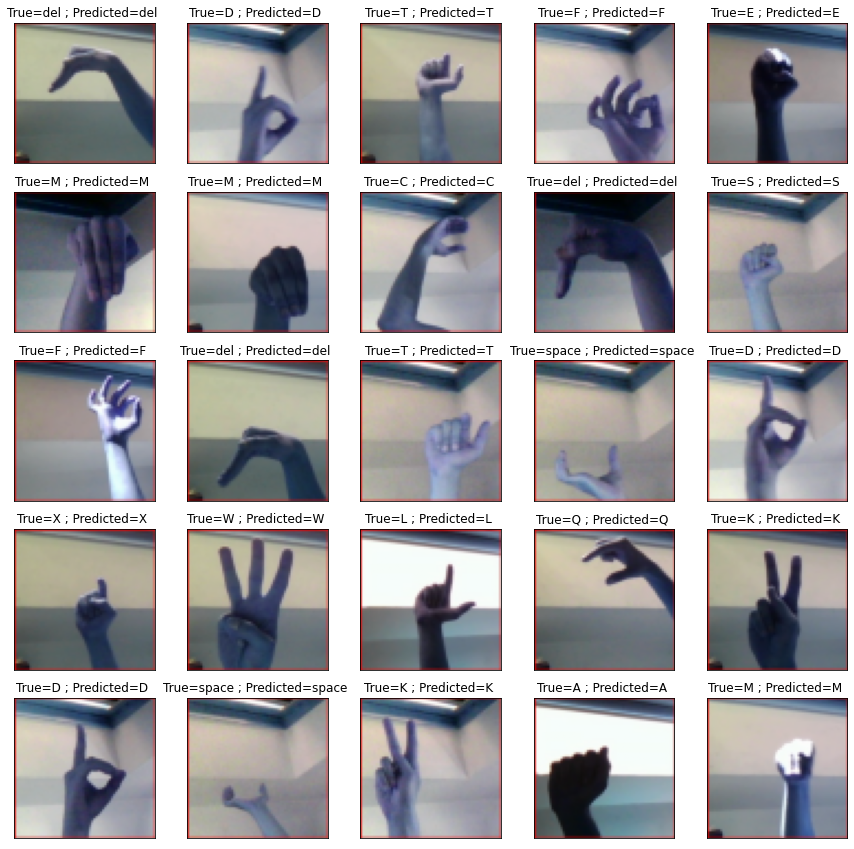

In [26]:
f, axs = plt.subplots(2,2,figsize=(15,15))
for i in range (0,25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img_nbr = np.random.randint(0,len(predictions))
    plt.imshow(X_test[img_nbr])
    plt.title("True={} ; Predicted={} ".format(classes[(y_test[img_nbr])], classes[(predictions[img_nbr])]))

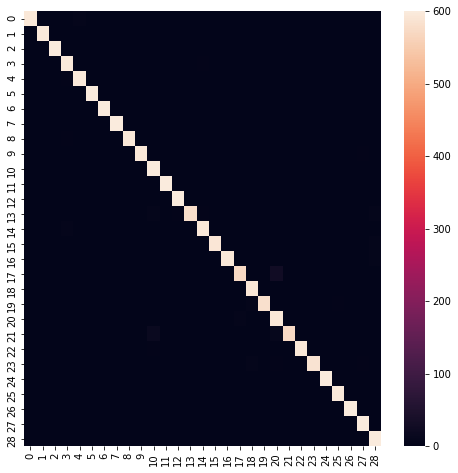

In [27]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,predictions))
plt.show()

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       600
           1       0.99      0.99      0.99       600
           2       1.00      1.00      1.00       600
           3       0.97      0.99      0.98       600
           4       0.99      0.99      0.99       600
           5       1.00      1.00      1.00       600
           6       0.99      1.00      1.00       600
           7       1.00      1.00      1.00       600
           8       1.00      0.99      1.00       600
           9       1.00      0.99      0.99       600
          10       0.96      1.00      0.98       600
          11       0.99      1.00      1.00       600
          12       0.99      1.00      0.99       600
          13       1.00      0.96      0.98       600
          14       0.99      0.99      0.99       600
          15       1.00      0.99      0.99       600
          16       1.00      0.99      0.99       600
          17       0.99    

Despues de trabajar con las 87000 imagenes las suposiciones fueron correctas y se pudo mejorar los resultados del modelo como podemos ver subimos de 0.95 a 0.99